In [38]:
#this notebook is where I played around with models -> looking for the best ones
   # I reran this notebook Monday afternoon, so some numbers may be slightly
              #        different than they were in my presentation!

#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

pd.options.display.max_colwidth = 400

In [39]:
df = pd.read_csv('./data/total-posts.csv')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,title,subreddit
0,Make real money from home,nfl
1,Would Georgia beat the ‘08 lions?,nfl
2,NFL Draft Predictions,nfl
3,"In your opinion, if Marty Schottenheimer had ended up with the Packers head coaching job in 2000, instead of Mike Sherman, what impact would this have had on the franchise in that decade?",nfl
4,What does this trade accomplish? I feel like I'm missing some grand Belichekian evil emperor scheme here,nfl


In [40]:
#train/test split
X = df['title']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

#vectorize the text
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [41]:
X_train_cv = pd.DataFrame(X_train_cv.A, columns=cv.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv.A, columns=cv.get_feature_names_out())

In [42]:
X_train_cv.shape, X_test_cv.shape 

((2247, 6021), (749, 6021))

In [43]:
#try a KNN model 
knn = KNeighborsClassifier()

knn.fit(X_train_cv, y_train)
knn.score(X_test_cv, y_test)

0.7222963951935915

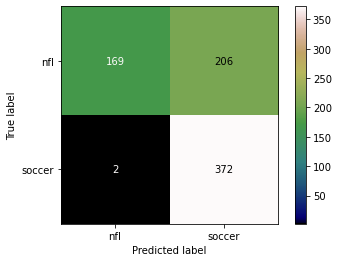

In [44]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_cv, y_test, cmap='gist_earth');

**Logistic Regression (using r/nfl and r/soccer data)** 

In [45]:
#I reran this model Monday afternoon and it is scoring slightly lower than it did in my presentation this morning
    #0.93 instead of 0.94
    
logreg = LogisticRegression()

logreg.fit(X_train_cv, y_train)
logreg.score(X_test_cv, y_test)

0.931909212283044

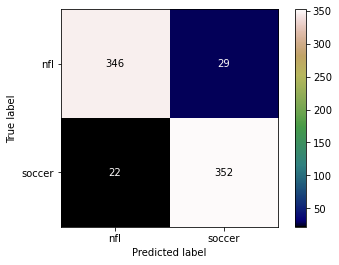

In [46]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cv, y_test, cmap='gist_earth');

**Try adding other sports subreddits to my model to see if it still does well:**
- Adding hockey, baseball, and basketball (nba)

In [53]:
df2 = pd.read_csv('./outputs/sports-clean.csv', index_col='Unnamed: 0')
#df2.drop(columns='Unnamed: 0.1', inplace=True)

#train/test split
X2 = df2['title']
y2 = df2['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X2, y2, stratify=y2)

#vectorize the text
cv = CountVectorizer(stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

X_train_cv = pd.DataFrame(X_train_cv.A, columns=cv.get_feature_names_out())
X_test_cv = pd.DataFrame(X_test_cv.A, columns=cv.get_feature_names_out())

In [54]:
#try a logistic regression model
logreg = LogisticRegression()

logreg.fit(X_train_cv, y_train)
logreg.score(X_test_cv, y_test)

0.8596584845250801

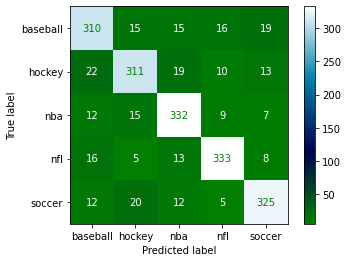

In [55]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_cv, y_test, cmap='ocean');

In [56]:
#try a random forest

forest = RandomForestClassifier()

forest.fit(X_train_cv, y_train)
forest.score(X_test_cv, y_test)

0.8404482390608324

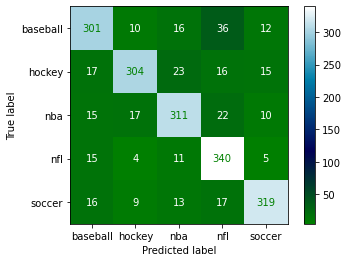

In [57]:
ConfusionMatrixDisplay.from_estimator(forest, X_test_cv, y_test, cmap='ocean');

In [58]:
#try an ensemble model

vc1 = VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('tree', RandomForestClassifier()),
    ('nb', MultinomialNB())
    ],
    voting='hard',
    weights=[.5,.4,.1],
    n_jobs=-1
)
vc1.fit(X_train_cv, y_train)
vc1.score(X_test_cv, y_test)

0.8628601921024547

In [59]:
#use Randomized Search on repeat to find better params 
    # I tweaked the params to search over several times (looked at hard and soft voting, 
    #       looked at a variety of weights)
    
params = {
    'weights' : [[.1,.1,.8], [.1,.8,.1], [.8,.1,.1]]
}

rs= RandomizedSearchCV(VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('tree', RandomForestClassifier()),
    ('nb', MultinomialNB())
    ], voting='soft'), params, n_jobs=-1)

rs.fit(X_train_cv, y_train)
rs.score(X_test_cv, y_test)

C:\Users\errog\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8681963713980789

In [91]:
rs.best_params_

{'weights': [0.1, 0.1, 0.8], 'voting': 'soft'}

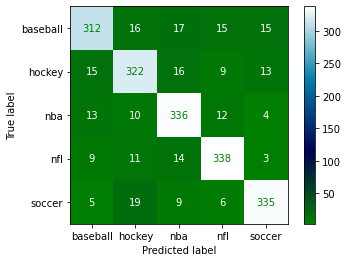

In [92]:
ConfusionMatrixDisplay.from_estimator(rs, X_test_cv, y_test, cmap='ocean');

In [60]:
#tried a random search with only weights 
     # tweaked weights several times here until getting a score I was happy with
    
params = {
    'weights' : [[.2,.2,.6], [.3,.3,.4], [.4,.3,.3], [5,.2,.3]]
}

gs= RandomizedSearchCV(VotingClassifier([
    ('logreg', LogisticRegression(max_iter=10_000)),
    ('tree', RandomForestClassifier()),
    ('nb', MultinomialNB())
    ], voting='soft'), params, n_jobs=-1)

gs.fit(X_train_cv, y_train)
gs.score(X_test_cv, y_test)

C:\Users\errog\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0.8815368196371398

In [61]:
gs.best_params_

{'weights': [0.4, 0.3, 0.3]}

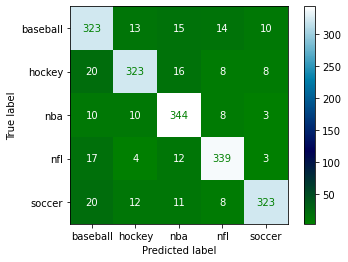

In [62]:
ConfusionMatrixDisplay.from_estimator(gs, X_test_cv, y_test, cmap='ocean');

In [63]:
#look at misclassified samples
test_preds = gs.predict(X_test_cv)

test_arr = y_test.to_numpy()
misclass = pd.DataFrame({'true class': test_arr, 'pred class': test_preds})
misclass = pd.concat([X_test_cv, misclass], axis=1)
#places where model is classifying model wrong
misclass = misclass[misclass['true class'] != misclass['pred class']]
misclass

,00,000,0007,001,00pm,01,010,018,02,025,...,موقعنا,وبنتها,南安普顿,水晶宫,突击检查,英超,메시,음바페,true class,pred class
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,nfl,hockey
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hockey,baseball
31,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,nba,nfl
35,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,nfl,hockey
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hockey,soccer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,hockey,nba
1859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,nfl,baseball
1863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,soccer,hockey
1866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,nfl,nba


In [65]:
misclass = misclass.drop(columns=['true class', 'pred class'])
misclass.sum().sort_values(ascending=False).head(25)

team        16
game        16
season      14
games       11
player      10
players     10
league       8
amp          8
year         8
ve           6
better       6
win          6
2022         6
playoffs     6
teams        5
years        5
pick         5
know         5
don          5
far          5
goal         5
does         5
good         5
think        5
second       5
dtype: int64

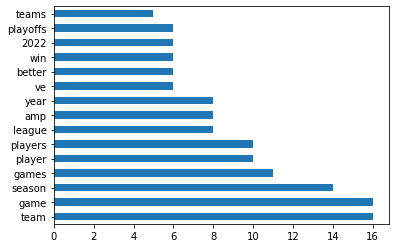

In [66]:
misclass.sum().sort_values(ascending=False).head(15).plot(kind='barh');

**Analysis of Misclassified Posts:** 
-  Some posts were ones that were using very general sports terminology - words like game, player, team, etc - which made it really hard on the model. Even as a human, looking at these words, I can’t tell where they are from.
- Some posts that were misidentified are mostly numbers and abbreviations (ex: 7IP, 0R, 2H) -> model might not know what to do with this since it isn't really language  
- Feeding the model more information could help - (adding comments perhaps) 